## _*Using Qiskit Algorithms's quantum evolution functionality*_

This notebook demonstrates how to realize quantum evolution using the `Qiskit Algorithms` library.

First, an Operator instance is created for our randomly generated Hamiltonian. We also randomly generate an initial quantum state `state_in`.

In [18]:
import numpy as np
from scipy.linalg import expm

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Operator
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import state_fidelity
from qiskit.primitives import StatevectorSampler

from qiskit_algorithms import TimeEvolutionProblem
from qiskit_algorithms import TrotterQRTE
from qiskit.quantum_info import SparsePauliOp

In [8]:
num_qubits = 2
evo_time = 0.3
temp = np.random.random((2 ** num_qubits, 2 ** num_qubits))
h1 = temp + temp.T
qubitOp = Operator(h1)
state_in_vector = np.random.random((2 ** num_qubits))
state_in = Statevector(state_in_vector / np.sqrt(np.dot(state_in_vector, state_in_vector)))

With the operator and the initial state, we can easily compute the groundtruth evolution result as follows.

In [9]:
groundtruth = expm(-1.j * h1 * evo_time) @ state_in.data
print(f'The directly computed groundtruth evolution result state is \n{groundtruth}')

The directly computed groundtruth evolution result state is 
[ 0.5165987 -0.27331566j  0.21565259-0.36949223j -0.09806499-0.47806547j
 -0.21508099-0.43700185j]


The `evolve` method as provided by the `TrotterQRTE` class also provides the ability to compute the evolution groundtruth via the Lie-Trotter-Suzuki product formula.Therefore, we can also compute the evolution's groundtruth result state as follows, which we can easily verify to be approximately the same as the `groundtruth` we just computed. The two result get closer as we reduce `evo_time` or increase `num_timesteps`.

In [10]:
H = SparsePauliOp.from_operator(h1)
problem = TimeEvolutionProblem(H, initial_state=state_in, time=evo_time)

trotter = TrotterQRTE(num_timesteps=3)
result = trotter.evolve(problem)

groundtruth_evolution = Statevector(result.evolved_state)
print('The groundtruth evolution result as computed by the Dynamics algorithm is\n{}.'.format(groundtruth_evolution))
print(f'Module of the difference between the two results: {np.sqrt((groundtruth - groundtruth_evolution.data) * np.conjugate(groundtruth - groundtruth_evolution.data)).real}')

The groundtruth evolution result as computed by the Dynamics algorithm is
Statevector([ 0.53095106-0.28451975j,  0.21192661-0.37843785j,
             -0.11947378-0.46275027j, -0.23608179-0.40603568j],
            dims=(2, 2)).
Module of the difference between the two results: [0.01820774 0.00969056 0.02632283 0.03741573]


Next, let's actually plot and then simulate the quantum circuit, which involves the circuit for putting the system in the specified initial state, and the actual evolution circuit corresponding to the operator we generated, for which, let's, for example, use the 3rd order `suzuki` expansion.

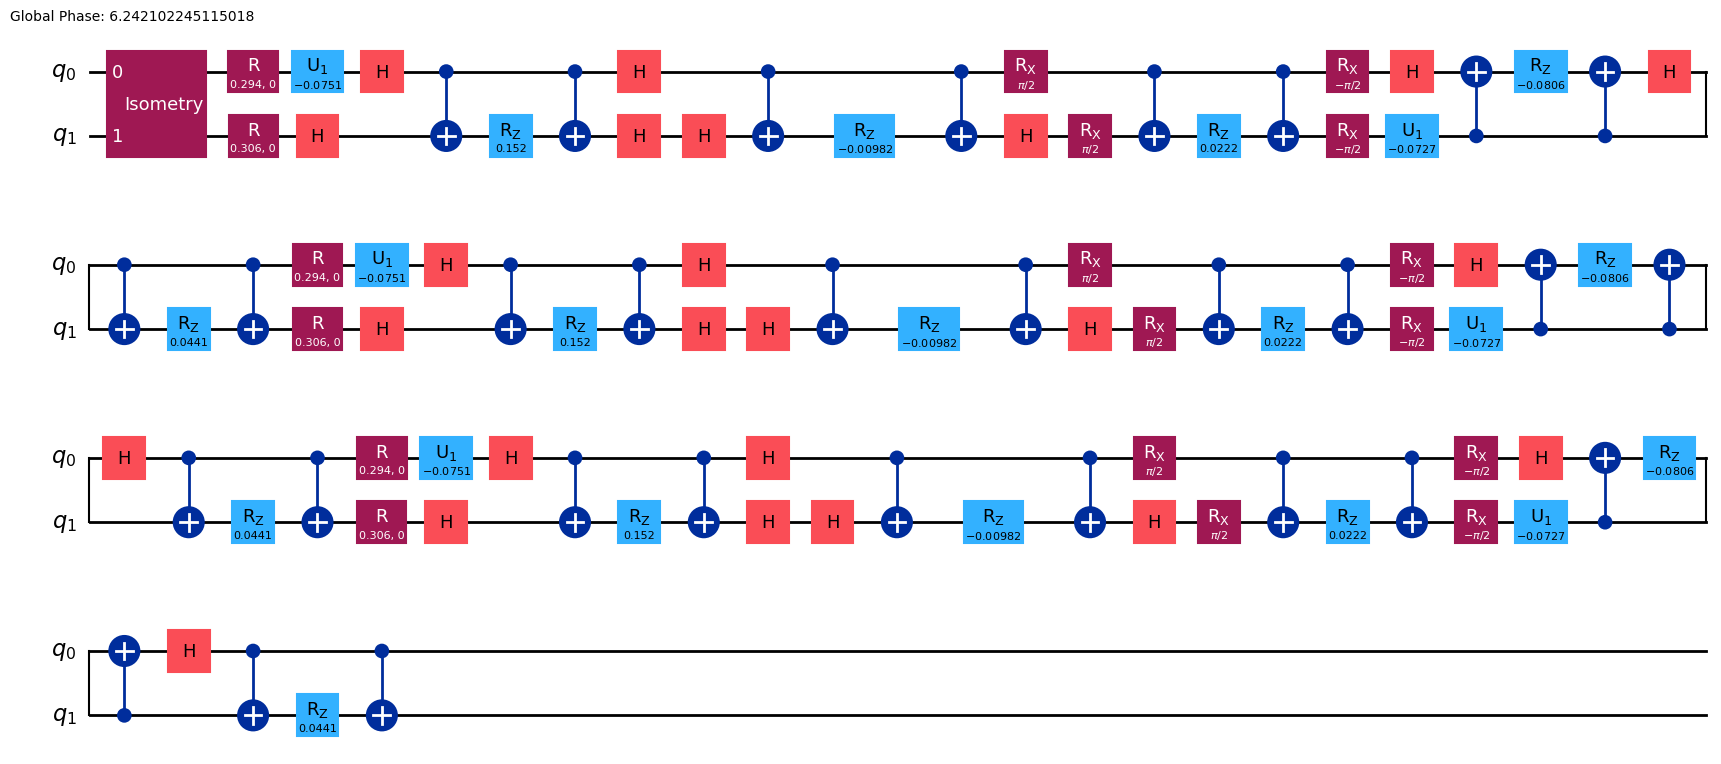

In [ ]:
result.evolved_state.decompose(reps=2).decompose("disentangler_dg").decompose(
    "multiplex1_reverse_dg"
).draw("mpl")

With the circuit built, we can now execute the circuit to get the evolution result. We use the `statevector_simulator` backend for the purpose of this demonstration.

In [17]:
circuit = result.evolved_state

final_statevector = Statevector(circuit)

We can then check the fidelity between the `groundtruth` and the `circuit_execution_result`.

In [20]:
print(f'Fidelity between the groundtruth and the circuit result states is {state_fidelity(groundtruth, final_statevector)}.')

Fidelity between the groundtruth and the circuit result states is 0.9985555938661932.


As seen, the fidelity is very close to `1`, indicating that the quantum circuit produced is a good approximation of the intended evolution.

In [21]:
! pip freeze | grep qiskit

qiskit==1.2.0
qiskit-aer==0.15.0
qiskit-algorithms==0.3.0
qiskit-ibm-runtime==0.31.0
qiskit-machine-learning==0.7.2
qiskit-nature==0.7.2
qiskit-nature-pyscf==0.4.0
qiskit-qasm3-import==0.5.0
qiskit-transpiler-service==0.4.5
